<Body>   
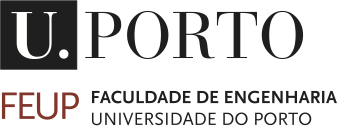   
<h1> <b>Advanced Topics on Machine Learning </b> </h1>
<p><b>Cátia Teixeira</b> (200808037) | <b>Henrique Bastos</b> (202204383) | <b>Ian Karkles</b> (202200596) | <b>Vitor Pereira</b> (202210497)
<p>Master in Data Science and Engineering</p>
</Body>
Faculdade de Engenharia da Universidade do Porto

---

# Data augmentation using cGAN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

import torch
from torch import nn
from torchsummary import summary
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from torch.utils.data import SubsetRandomSampler, DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torch.optim as optim
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

## Data preprocessing

In [2]:
df = pd.read_csv('/Users/henriqueribeiro/Downloads/creditcard.csv')

#split df into train and test
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [3]:
#print the characteristics of the dataframes
print('Train shape: ', df_train.shape)
print('Test shape: ', df_test.shape)

Train shape:  (227845, 31)
Test shape:  (56962, 31)


In [4]:
class FraudDataset(Dataset):
 
  def __init__(self, dataframe, fraud = True):
    scaler = StandardScaler()
    df = dataframe
    if fraud:
      df = df[df['Class'] == 1]
 
    x = df.iloc[:, 0:-1].values
    y = df.iloc[:, -1].values
    #y = np.reshape(y, (1,-1))
    
    # Standardize data
    #x = scaler.fit_transform(x)
    #y = scaler.fit_transform(y)

    self.x_data=torch.tensor(x,dtype=torch.float32)
    self.y_data=torch.tensor(y,dtype=torch.float32)

    self.features = x.shape[1]
  def __len__(self):
    return len(self.x_data)
   
  def __getitem__(self,idx):
    return self.x_data[idx], self.y_data[idx]

creditData = FraudDataset(df_train, fraud= True)
creditDataTest = FraudDataset(df_test, fraud= True)

In [6]:
train_dataloader = DataLoader(creditData, batch_size=64, drop_last=True)
test_dataloader = DataLoader(creditDataTest, batch_size=64, drop_last=True)

## Conditional Generative Adversarial Network

### Architecture

In [8]:
class Generator(nn.Module):
    def __init__(self, latent_dim, nr_features):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, nr_features)
        )
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return torch.sigmoid(x)

In [9]:
class Discriminator(nn.Module):
    def __init__(self, nr_features):
        super().__init__()
        self.layers = nn.Sequential(
           nn.Linear(nr_features, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(inplace = True),
            nn.Dropout2d(0.2),
            
            nn.Linear(512, 256),
            nn.ReLU(inplace = True),
            nn.Dropout2d(0.2),
            
            nn.Linear(256, 128),
            nn.ReLU(inplace = True),
            nn.Dropout2d(0.2),
            
            nn.Linear(128, 64),
            nn.ReLU(inplace = True),
            nn.Dropout2d(0.2),
            
            nn.Linear(64, 32),
            nn.ReLU(inplace = True),
            nn.Dropout2d(0.2),
            
            nn.Linear(32, 16),
            nn.ReLU(inplace = True),
            nn.Dropout2d(0.2),
            
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
            
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return torch.sigmoid(x)

In [15]:
#define device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

latent_dim = 7
nr_features = 30

#create optimizer for the generator
generator = Generator(latent_dim, nr_features).to(device)
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)

#create optimizer for the descriminator
discriminator = Discriminator(nr_features)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)

print(f"Using {device} device")


Using cpu device


In [ ]:
print('\t\t\tGenerator')
summary(generator, input_size=(latent_dim,))

In [ ]:
print('\t\t\tDiscriminator')
summary(discriminator, input_size=(nr_features,))

####  Loss Function + Device + Reset Gradients Funct.

In [10]:
criterion = nn.BCELoss()

In [11]:
def train_generator(opt_g, cur_batch_size, criterion):
    # Clear generator gradients
    opt_g.zero_grad()
    
   
    fake_targets = torch.ones((cur_batch_size),  device = device)
    
    # random noise from uniform distribution
    latent_space_samples = torch.randn((cur_batch_size, latent_dim),  device = device)
    generated_data = generator(latent_space_samples)  # fake data generated by generator
    fake_preds = discriminator(generated_data).reshape(-1)
    g_loss = criterion(fake_preds, fake_targets)

    g_loss.backward()
    opt_g.step()
    
    return g_loss, generated_data

In [12]:
def train_discriminator(real_data, opt_d, cur_batch_size):
    # Reset gradients
    opt_d.zero_grad()
    
   
    #real_labels = df_fraud['Class'].to_numpy() #sendo que estamos 
    
    real_labels = torch.ones((cur_batch_size), device=device)
    
    real_preds = discriminator(real_data).reshape(-1)
    d_loss_real = criterion(real_preds, real_labels)
    
    fake_labels = torch.zeros((cur_batch_size),  device = device)
    # random noise from uniform distribution
    latent_space_samples = torch.randn((cur_batch_size, latent_dim),  device = device)
    
    generated_data = generator(latent_space_samples)  # fake data generated by generator
    fake_preds = discriminator(generated_data).reshape(-1)
    d_loss_fake = criterion(fake_preds, fake_labels)
    
    loss = d_loss_real + d_loss_fake

    # Compute gradients
    loss.backward()
    # Adjust the parameters using backprop
    opt_d.step()
    
        
    return loss

In [13]:
class GAN:
    def __init__(self, train_df, latent_size=128):
        self.lr = 0.0002
        self.batch_size = 64
        self.n_critic = 5
        self.clip_value = 0.01

        self.dataset = FraudDataset(train_df, fraud= True)
        self.dataloader = DataLoader(self.dataset, self.batch_size, shuffle=True)

        self.G = Generator(latent_dim=latent_size, nr_features=self.dataset.features).to(device)
        self.D = Discriminator(nr_features=self.dataset.features).to(device)
        self.latent_size = latent_size

        self.g_optimizer = torch.optim.Adam(self.G.parameters(), lr=0.0002)
        self.d_optimizer = torch.optim.Adam(self.D.parameters(), lr=0.0002)

    def train(self,real_data, cur_batch_size, epochs=1000):
        losses_gen = []
        losses_dis = []
        generated_data = None
        for epoch in range(epochs):
            for i, (real_data, real_labels)  in enumerate(self.dataloader):
                cur_batch_size = real_data.shape[0] #check this
                # Train discriminator
                dis_loss = train_discriminator(real_data, discriminator_optimizer, cur_batch_size)
                #print(f'Discriminator loss {dis_loss:.3f}')

                # Clip weights of discriminator
                for p in self.D.parameters():
                    p.data.clamp_(-self.clip_value, self.clip_value)

                # Train generator every n_critic iterations
                if i % self.n_critic == 0:
                    gen_loss, generated_data_batch = train_generator(generator_optimizer, cur_batch_size, criterion)
                    generated_data = generated_data_batch if generated_data is None else torch.cat((generated_data, generated_data_batch))

                    #print(f'Generator loss: {gen_loss:.3f}')
                

                losses_gen.append(gen_loss)
                losses_dis.append(dis_loss)

            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f} \n'
                .format(epoch, epoch, i+1, len(self.dataloader), dis_loss.item(), gen_loss.item()))
            
        return losses_gen, losses_dis, generated_data



    def sample(self, count):
        with torch.no_grad():
            z = torch.Tensor(np.random.normal(0, 1, (count, self.latent_size))).to(device)
            gen = self.G(z)
            return gen.cpu().numpy()

In [16]:
gan = GAN(df_train)

In [17]:
losses_gen, losses_dis, _ = gan.train(df_train, 64, epochs=200)

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch [0/0], Step [7/7], d_loss: 1.3135, g_loss: 0.4588 

Epoch [1/1], Step [7/7], d_loss: 1.3102, g_loss: 0.4587 

Epoch [2/2], Step [7/7], d_loss: 1.3144, g_loss: 0.4603 

Epoch [3/3], Step [7/7], d_loss: 1.3114, g_loss: 0.4607 

Epoch [4/4], Step [7/7], d_loss: 1.3089, g_loss: 0.4612 

Epoch [5/5], Step [7/7], d_loss: 1.3099, g_loss: 0.4624 

Epoch [6/6], Step [7/7], d_loss: 1.3081, g_loss: 0.4634 

Epoch [7/7], Step [7/7], d_loss: 1.3017, g_loss: 0.4651 

Epoch [8/8], Step [7/7], d_loss: 1.3375, g_loss: 0.4668 

Epoch [9/9], Step [7/7], d_loss: 1.2933, g_loss: 0.4686 

Epoch [10/10], Step [7/7], d_loss: 1.2790, g_loss: 0.4772 

Epoch [11/11], Step [7/7], d_loss: 1.2593, g_loss: 0.4942 

Epoch [12/12], Step [7/7], d_loss: 1.2334, g_loss: 0.5375 

Epoch [13/13], Step [7/7], d_loss: 1.1079, g_loss: 0.6002 

Epoch [14/14], Step [7/7], d_loss: 1.0248, g_loss: 0.6606 

Epoch [15/15], Step [7/7], d_loss: 1.0227, g_loss: 0.6812 

Epoch [16/16], Step [7/7], d_loss: 1.0132, g_loss: 0.6884 



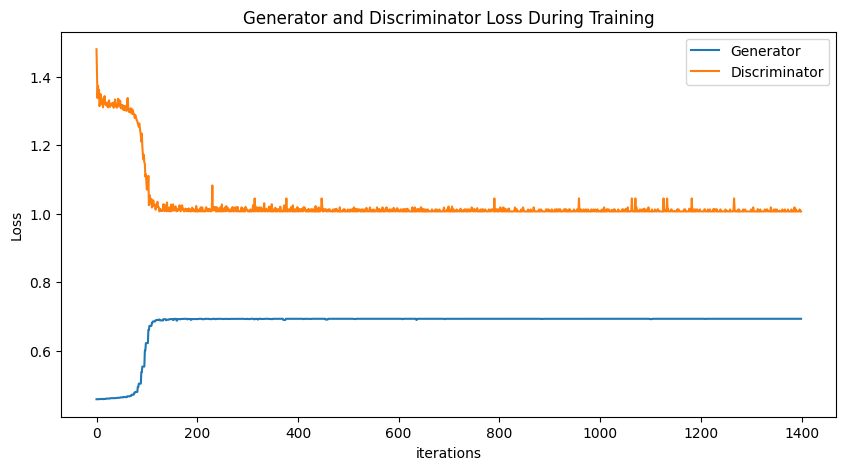

In [24]:
def plot_losses(losses_gen, losses_dis):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")

    #convert losses into numpy
    losses_gen = [i.detach().numpy() for i in losses_gen]
    losses_dis = [i.detach().numpy() for i in losses_dis]
    plt.plot(losses_gen,label="Generator")
    plt.plot(losses_dis,label="Discriminator")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_losses(losses_gen, losses_dis)

In [18]:
sample_number = df_train[df_train['Class'] == 0].shape[0]
gan_samples = gan.sample(sample_number)
samples_test = np.append(gan_samples, np.ones((sample_number, 1)), axis=1)
wgan_df = pd.DataFrame(samples_test, columns=df_train.columns)
#concat wgan_df with df_train
df_concat = pd.concat([df_train, wgan_df], ignore_index=True)

In [19]:
df_concat['Class'].value_counts()

Class
1.0    227845
0.0    227451
Name: count, dtype: int64

### Model evaluation

In [21]:
class Model(nn.Module):
    def __init__(self, nr_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(nr_features, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return torch.flatten(self.model(x))

In [22]:
class FraudModel:
    def __init__(self, train_df):
        self.lr = 0.0001
        self.batch_size = 64
        self.dataset = FraudDataset(train_df, fraud = False)
        self.dataloader = DataLoader(self.dataset, self.batch_size, shuffle=True)
        self.model = Model(nr_features=self.dataset.features).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.loss = nn.BCELoss()

    def train(self, epochs=100):
        for epoch in range(epochs):
            epoch_loss = 0
            for _, (x, y) in enumerate(self.dataloader):
                self.optimizer.zero_grad()
                y_pred = self.model(x)
                loss = self.loss(y_pred, y)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item() / len(x)
            print("[Epoch %d/%d] loss: %f" % (epoch, epochs, np.mean(epoch_loss)))

    def predict(self, x):
        with torch.no_grad():
            pred = self.model(x)
            return pred.cpu().numpy()
        
    def evaluate(self, test_df, confidence=0.50):
        input = torch.Tensor(test_df.drop(['Class'], axis=1).values).to(device)
        preds = self.predict(input)
        labels = np.zeros_like(preds)
        labels[preds >= confidence] = 1
        ConfusionMatrixDisplay.from_predictions(test_df['Class'].values, labels, normalize='true')
        print(classification_report(test_df['Class'].values, labels))

[Epoch 0/100] loss: 3.918881
[Epoch 1/100] loss: 4.295452
[Epoch 2/100] loss: 3.888506
[Epoch 3/100] loss: 2.649154
[Epoch 4/100] loss: 1.580212
[Epoch 5/100] loss: 2.214003
[Epoch 6/100] loss: 1.561609
[Epoch 7/100] loss: 1.417715
[Epoch 8/100] loss: 1.637706
[Epoch 9/100] loss: 1.258202
[Epoch 10/100] loss: 0.822062
[Epoch 11/100] loss: 0.817724
[Epoch 12/100] loss: 1.109685
[Epoch 13/100] loss: 0.521082
[Epoch 14/100] loss: 0.677670
[Epoch 15/100] loss: 0.574421
[Epoch 16/100] loss: 0.457986
[Epoch 17/100] loss: 0.688315
[Epoch 18/100] loss: 0.393783
[Epoch 19/100] loss: 0.550302
[Epoch 20/100] loss: 0.437759
[Epoch 21/100] loss: 0.573740
[Epoch 22/100] loss: 0.490869
[Epoch 23/100] loss: 0.549488
[Epoch 24/100] loss: 0.519934
[Epoch 25/100] loss: 0.403575
[Epoch 26/100] loss: 0.464823
[Epoch 27/100] loss: 0.458501
[Epoch 28/100] loss: 0.462012
[Epoch 29/100] loss: 0.475009
[Epoch 30/100] loss: 0.731495
[Epoch 31/100] loss: 0.612194
[Epoch 32/100] loss: 0.390037
[Epoch 33/100] loss:

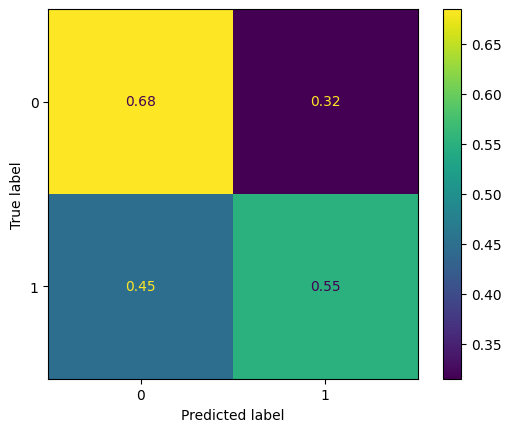

In [23]:
fw_model = FraudModel(df_concat)
fw_model.train(epochs=100)
fw_model.evaluate(df_test, confidence=0.90)